<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/eras/eras/tune/programs/0109Tester_TuningYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#共通設定

In [1]:
%tensorflow_version 2.x

#ツール

In [60]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

#スクラッチ

In [ ]:
del model
keras.backend.clear_session()
gc.collect()

# モジュールインポート

In [31]:
# file dealing
import os
from os import path
import shutil
from google.colab import drive
# data dealing
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc

# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks

# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical


#ディレクトリ環境設定

In [32]:
def make_dirStruct():
  # gdrive 接続
  if not path.exists('/content/drive'):
    drive.mount('/content/drive')
  else:
    print("Already confirm")
  # colab テンポラリディレクトリの作成
  desk = '/content/desk'
  if not os.path.exists(desk):
    os.mkdir(desk)
  os.chdir(desk)
  print("Created at /content/desk")
  return desk

In [ ]:
desk = make_dirStruct()

Mounted at /content/drive
Created at /content/desk


# データフォーマットを規定

In [4]:
class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLORinfo = 3 # "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値

format1 = video_format()

#データをインポート

In [ ]:
# 必要なファイルを'desk'にコピー
%%time
wants_paths = [
'/content/drive/MyDrive/colab/dence1223/normalTrainLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTrainVideos.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestVideos.npz'
]

for want in wants_paths:
  if not os.path.exists(os.path.join(desk, os.path.basename(want))):
    shutil.copy2(want, desk)
    print("get : ", want)
            

In [8]:
# ファイルをメモリにコピー
def prepare_data():
  # traindata
  v = np.load('/content/desk/normalTrainVideos.npz')
  l = np.load('/content/desk/normalTrainLabels.npz')

  train_videos = [] 
  train_labels = []
  for i in v.files:
    train_videos.append(v[i])
  for i in l.files:
    train_labels.append(l[i])

  train_videos = np.array(train_videos)
  train_labels = np.array(train_labels)
  train_labels = tf.keras.utils.to_categorical(train_labels, 4)

  # testdata
  v = np.load('/content/desk/normalTestVideos.npz')
  l = np.load('/content/desk/normalTestLabels.npz')

  test_videos = []
  test_labels = []
  for i in v.files:
    test_videos.append(v[i])
  for i in l.files:
    test_labels.append(l[i])

  test_videos = np.array(test_videos)
  test_labels = np.array(test_labels)
  test_labels = tf.keras.utils.to_categorical(test_labels, 4)
  
  return train_videos, train_labels,  test_videos, test_labels

In [9]:
train_videos, train_labels,  test_videos, test_labels = prepare_data()

#モデル作成

In [10]:
seed = 20201218
np.random.seed(seed)
tf.random.set_seed(seed)

In [135]:
# モデル作成
model = models.Sequential()
# 入力層
model.add(
     layers.Reshape(
        (format1.FRAME_SIZE,
         format1.HEIGHT,
         format1.WIDTH,
         format1.COLORinfo),
        input_shape=(format1.FRAME_SIZE * format1.HEIGHT * format1.WIDTH * format1.COLORinfo,),
        name='ENTRANCE' )
)
# 中間層
## dropout_0
# model.add(layers.Dropout(0.2))

## 畳み込み0
model.add(
    layers.Conv3D(
        filters=32,
        kernel_size=(2, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv0'))
## pool0
model.add(
    layers.MaxPooling3D(pool_size=(2, 3, 3), name='pool0'))

## 畳み込み1
model.add(
    layers.Conv3D(
        filters=64,
        kernel_size=(2, 3, 3),
        strides=(1, 1, 1),
        padding='same',
        activation='relu',
        name='conv1'))
## pool1
model.add(
    layers.MaxPooling3D(pool_size=(2, 3, 3), name='pool1'))


## dropout_1
# model.add(layers.Dropout(0.2))

## 全結合0
model.add(
    layers.Flatten(name='pipe'),
)
model.add(
    layers.Dense(1024,
      activation='relu',
      name='DAM' ),
)
# 出力層
model.add(
    layers.Dense(4, activation='softmax', name='WATERSUPPLY')
)

# 最適化
adam = keras.optimizers.Adam(
    lr=1e-7, beta_1=0.9, beta_2=0.999,
    epsilon=None, decay=0.0, amsgrad=False)
# 誤差関数
mse = tf.keras.losses.MeanSquaredError()
cce = tf.keras.losses.CategoricalCrossentropy()

model.compile(
    optimizer=adam,
    loss=cce,
    metrics=['acc', cce])

#学習実行

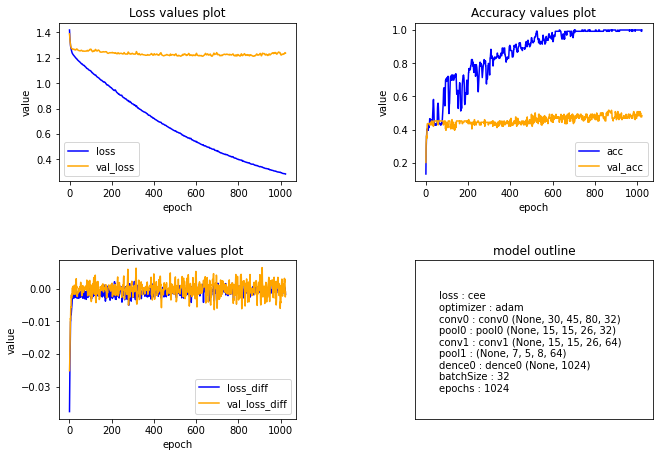

In [133]:
def plot(history, name='tmp'):
  HEIGHT = 2
  WIDTH = 2

  # 下地の用意
  fig = plt.figure()
  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1)
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2)
  LOSSDIF = fig.add_subplot(HEIGHT, WIDTH, 3)
  MODEL_OUTLINE = fig.add_subplot(HEIGHT, WIDTH, 4)


  plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.5, wspace=0.5, hspace=0.5)

  # 1,1 loss
  loss = DataFrame(history.history['loss'])
  val_loss = DataFrame(history.history['val_loss'])
  loss_props = {
        'title' : 'Loss values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', color='blue')
  LOSS.plot(val_loss, label='val_loss', color='orange')
  LOSS.legend(loc='best')

  # 1,2 acc
  acc = DataFrame(history.history['acc'])
  val_acc = DataFrame(history.history['val_acc'])
  acc_props = {
        'title' : 'Accuracy values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  ACC.set(**acc_props)
  ACC.plot(acc, label='acc', color='blue')
  ACC.plot(val_acc, label='val_acc', color='orange')
  ACC.legend(loc='best')

  #2,1 loss.diff
  loss_diff_props = {
      'title' : 'Derivative values plot',
      'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  LOSSDIF.set(**loss_diff_props)
  LOSSDIF.plot(loss.diff(), label='loss_diff', color='blue')
  LOSSDIF.plot(val_loss.diff(), label='val_loss_diff', color='orange')
  LOSSDIF.legend(loc='best')

  #2, 2 model outline
  
  tmp = {
      'title' : 'model outline',
      'xticks' : ([]),
      'yticks' : ([]),
  }

  MODEL_OUTLINE.set(**tmp)
  MODEL_OUTLINE.text(0.1, 0.1, modelOutline(), size=10)

  #save
  path_image = os.path.join(desk, name)
  fig.savefig(path_image, bbox_inches='tight')

def modelOutline():
  sentence = ""
  elements = {
      "loss" : "cee",
      "optimizer" : "adam",
      "conv0" : "conv0 (None, 30, 45, 80, 32)",
      "pool0" : "pool0 (None, 15, 15, 26, 32)",
      "conv1" : "conv1 (None, 15, 15, 26, 64)",
      "pool1" : "(None, 7, 5, 8, 64)",
      "dence0" : "dence0 (None, 1024)",

      "batchSize" : "32",
      "epochs" : "1024",
  }

  for each in elements.keys():
    sentence = sentence + each + " : " + elements[each] + "\n"

  return sentence

plot(history)

In [ ]:
%%time
# 実行
history = model.fit(
      train_videos, train_labels,
      validation_data=(test_videos, test_labels),
      batch_size=64,
      epochs=2048,
      verbose=0
      )

print("Complete.")
# プロット
plot(history)

# 消去
sleep(10)
del model
keras.backend.clear_session()
gc.collect()

beep()
